# Workflow to tile the stainunstain images to 1024 x 1024 size

In [10]:
import numpy as np
import time
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
from matplotlib import pyplot as plt
import os
import math
import cv2
import numpy as np
import pandas as pd
from skimage.morphology import remove_small_objects, remove_small_holes

In [22]:
stainsrc = r'\\shelter\Kyu\unstain2stain\biomax_images\stained\padded_images\sk244a'
stainlist = [_ for _ in os.listdir(stainsrc) if _.endswith('.png')]
stainlist_name = [x.replace(".png", "") for x in stainlist]
stainlist_path = [os.path.join(stainsrc,x) for x in stainlist]

unstainsrc = r'\\shelter\Kyu\unstain2stain\biomax_images\registrated_images\sk244a'
unstainlist = [_ for _ in os.listdir(unstainsrc) if _.endswith('.png')]
unstainlist_name = [x.replace(".png", "") for x in unstainlist]
unstainlist_path = [os.path.join(unstainsrc,x) for x in unstainlist]


In [61]:
unstain_img = Image.open(unstainlist_path[1])
stain_img = Image.open(stainlist_path[1])
stain_img_ra = np.array(stain_img) # shape H X W x 4 RGBA
unstain_img_ra = np.array(unstain_img) # shape H X W x 3 RGB

(404, 453)

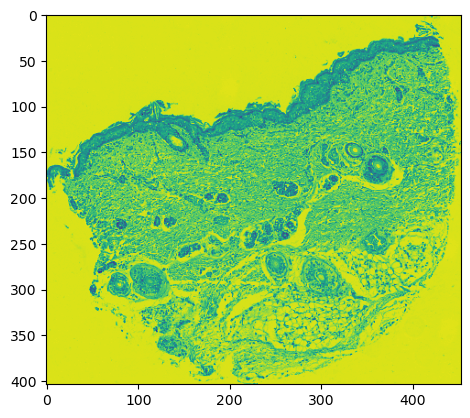

In [62]:
# create mask of stain img:
stainbw = cv2.cvtColor(stain_img_ra,cv2.COLOR_RGBA2RGB)
stainbw = cv2.cvtColor(stainbw,cv2.COLOR_RGB2GRAY)
stainbw = cv2.resize(stainbw,(stainbw.shape[1]//16,stainbw.shape[0]//16),interpolation = cv2.INTER_AREA)

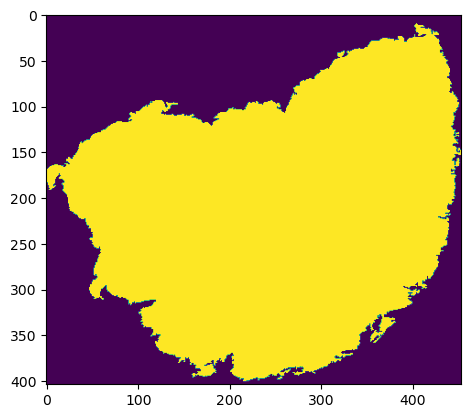

In [63]:
stainbw1 = stainbw<230
stainbw2 = remove_small_objects(stainbw1, 1000)
stainbw3 = remove_small_holes(stainbw2, 3000)
plt.imshow(stainbw3)

In [76]:
width= stainbw3.shape[0]
height= stainbw3.shape[1]
tile_size = 1024/16
num_cols = int(math.floor(width / tile_size))
num_rows = int(math.floor(height / tile_size))
output_dir = r'\\shelter\Kyu\unstain2stain\biomax_images\tiled_images'
# Loop over each tile
for row in range(num_rows):
    for col in range(num_cols):
        # Compute the bounding box for this tile
        left = col * tile_size
        upper = row * tile_size
        right = min((col + 1) * tile_size, width)
        lower = min((row + 1) * tile_size, height)

        # Crop the image to the bounding box
        tile = stainbw3[int(upper):int(lower),int(left):int(right)]
        if np.sum(tile) <=  (1024/16)**2 * 0.8:
            continue
        real_left = left * 16
        real_upper = upper * 16
        real_right = right * 16
        real_lower = lower * 16

        stain_crop = stain_img.crop((real_left,real_upper,real_right,real_lower))
        unstain_crop = unstain_img.crop((real_left,real_upper,real_right,real_lower))
        stain_filename = os.path.join(output_dir, f"{row}_{col}_stain.png")
        unstain_filename = os.path.join(output_dir, f"{row}_{col}_unstain.png")
        stain_crop.save(stain_filename)
        unstain_crop.save(unstain_filename)


In [7]:
def tile_image(stain_path, unstain_path, stain_output_dir, unstain_output_dir, desired_mask_rsf = 16, desired_tile_size = 1024):
    """
    Takes an input image and tiles it into smaller images of size tile_size.
    Saves the resulting images to the output_dir directory.
    Input img1, img2 is a file path for img1 and img2, tile_size must be a single number (tile is square).
    """
    stainlist = [_ for _ in os.listdir(stain_path) if _.endswith('.png')]
    stainlist_name = [x.replace(".png", "") for x in stainlist]
    stainlist_path = [os.path.join(stainsrc,x) for x in stainlist]

    unstainlist = [_ for _ in os.listdir(unstain_path) if _.endswith('.png')]
    unstainlist_name = [x.replace(".png", "") for x in unstainlist]
    unstainlist_path = [os.path.join(unstainsrc,x) for x in unstainlist]

    if not len(stainlist_path) == len(unstainlist_path):
        raise Exception("Length of stain image list and unstain image list must be the same with same order.")

    for idx in range(0,len(stainlist_path)):
        unstain_img = Image.open(unstainlist_path[idx])
        stain_img = Image.open(stainlist_path[idx])
        stain_img_ra = np.array(stain_img) # shape H X W x 4 RGBA
        # unstain_img_ra = np.array(unstain_img) # shape H X W x 3 RGB

        # create mask of stain img:
        stainbw = cv2.cvtColor(stain_img_ra,cv2.COLOR_RGBA2RGB)
        stainbw = cv2.cvtColor(stainbw,cv2.COLOR_RGB2GRAY)
        stainbw = cv2.resize(stainbw,(stainbw.shape[1]//desired_mask_rsf,stainbw.shape[0]//desired_mask_rsf),interpolation = cv2.INTER_AREA)
        stainbw1 = stainbw<230
        stainbw2 = remove_small_objects(stainbw1, 1000)
        stainbw3 = remove_small_holes(stainbw2, 3000)

        width= stainbw3.shape[0]
        height= stainbw3.shape[1]
        tile_size = desired_tile_size/desired_mask_rsf
        num_cols = int(math.floor(width / tile_size))
        num_rows = int(math.floor(height / tile_size))
        output_dir = r'\\shelter\Kyu\unstain2stain\biomax_images\tiled_images'

        for row in range(num_rows):
            for col in range(num_cols):
                # Compute the bounding box for this tile
                left = col * tile_size
                upper = row * tile_size
                right = min((col + 1) * tile_size, width)
                lower = min((row + 1) * tile_size, height)

                # Crop the image to the bounding box
                tile = stainbw3[int(upper):int(lower),int(left):int(right)]
                if np.sum(tile) <=  (1024/16)**2 * 0.8:
                    continue
                real_left = left * 16
                real_upper = upper * 16
                real_right = right * 16
                real_lower = lower * 16

                stain_crop = stain_img.crop((real_left,real_upper,real_right,real_lower))
                unstain_crop = unstain_img.crop((real_left,real_upper,real_right,real_lower))
                stain_filename = os.path.join(output_dir, f"{row}_{col}_stain.png")
                unstain_filename = os.path.join(output_dir, f"{row}_{col}_unstain.png")
                stain_crop.save(stain_filename)
                unstain_crop.save(unstain_filename)

In [10]:
img1 = Image.open(unstainlist_path[0])
tile_image(img1, 1024, r'\\shelter\Kyu\unstain2stain\biomax_images\tiled_images')

C:\Users\labuser\AppData\Local\Temp\ipykernel_6740\3823649124.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  nonwhite_pixels = np.sum(np.array(tile) != 255 * np.ones((tile_size, tile_size, 3), dtype=np.uint8))
